# Debugging Factor Analysis Implementation

This notebook investigates the Factor Analysis implementation step by step, focusing on:
1. Data generation
2. E-step computation
3. M-step updates
4. Full model fitting

In [1]:
import numpy as np
try:
    from sklearn.decomposition import FactorAnalysis as sklearn_fa
except:
    !pip install scikit-learn
    from sklearn.decomposition import FactorAnalysis as sklearn_fa
try:
    import procrustes
except:
    !pip install qc-procrustes
    import procrustes

In [2]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns 
import equinox as eqx
from jax import config
from sppcax.models import PPCA, PFA
from sppcax.distributions import MultivariateNormal, MultivariateNormalGamma

# For better visualization
%matplotlib inline
sns.set_theme('notebook', style='dark', palette="deep")
config.update("jax_enable_x64", True)

/home/dima/Dropbox/development/python/sppcax/src/sppcax/models/factor_analysis_algorithms.py:223: SyntaxWarning: invalid escape sequence '\p'
  """Compute expected log likelihood E_q[log p(X|Z,W, \psi)].


## 1. Data Generation

First, let's generate synthetic data with known structure:

Data shapes:
X: (100, 10)
Z_true: (100, 3)
W_true: (3, 10)


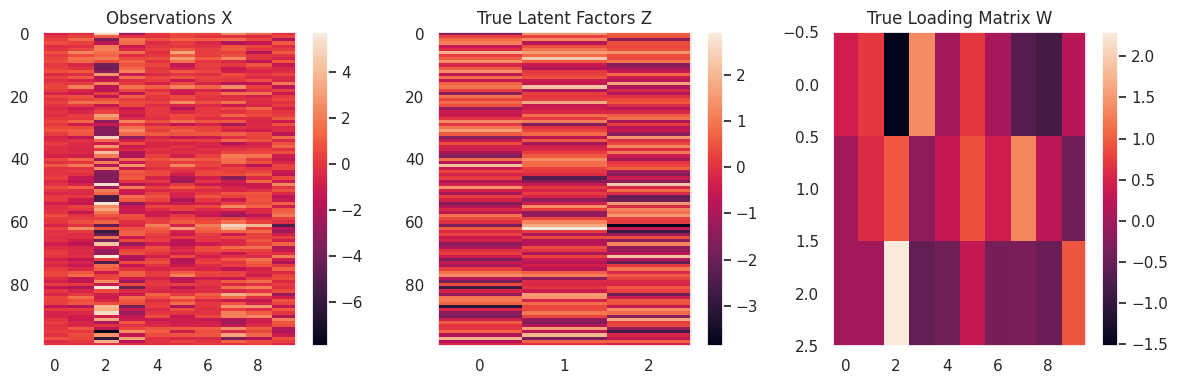

In [3]:
# Set random seed for reproducibility
key = jr.PRNGKey(0)

# Data dimensions
n_samples = 100
n_features = 10
n_components = 3

assert (n_features - n_components)**2 >= n_features + n_components

mask = jnp.transpose(jnp.clip(jnp.arange(n_features), a_max=n_components)[..., None] >= jnp.arange(n_components))

# Generate true latent factors
key, subkey = jr.split(key)
Z_true = jr.normal(subkey, (n_samples, n_components))

# Generate true loading matrix with some features being noise
key, subkey = jr.split(key)
W_true = jr.normal(subkey, (n_components, n_features)) * mask

# Generate observations with noise
key, subkey = jr.split(key)
noise = 0.1 * jr.normal(subkey, (n_samples, n_features))
X = Z_true @ W_true + noise

print("Data shapes:")
print(f"X: {X.shape}")
print(f"Z_true: {Z_true.shape}")
print(f"W_true: {W_true.shape}")

# Visualize the data
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(X, aspect='auto')
plt.title('Observations X')
plt.colorbar()

plt.subplot(132)
plt.imshow(Z_true, aspect='auto')
plt.title('True Latent Factors Z')
plt.colorbar()

plt.subplot(133)
plt.imshow(W_true, aspect='auto')
plt.title('True Loading Matrix W')
plt.colorbar()

plt.tight_layout()

The Procrustes error for the loading matrix is 1.1283958694033875


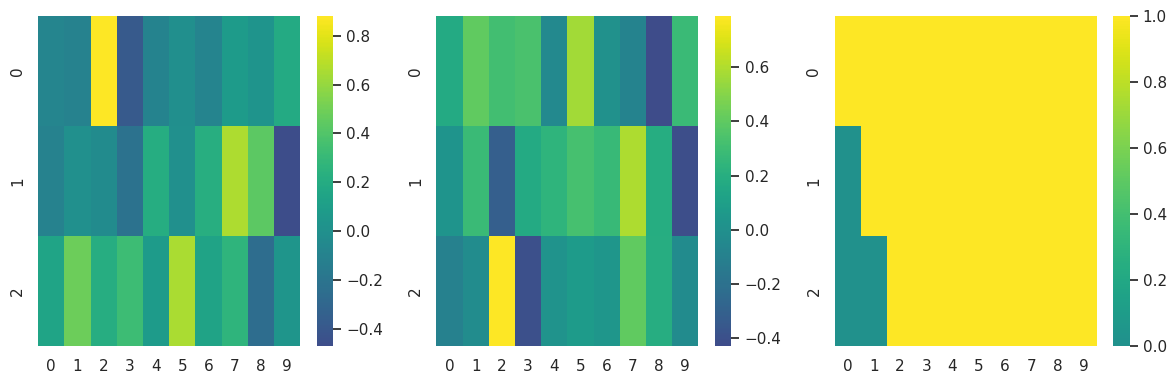

In [4]:
z_dim = n_components
u, s, v = jnp.linalg.svd(X - X.mean(0), full_matrices=False)
pca_w = v[:z_dim]

proc_trans = procrustes.orthogonal(np.asarray(pca_w.T), np.asarray(mask.T).astype(jnp.float32), scale=True)
print(f"The Procrustes error for the loading matrix is {proc_trans.error}")

# Heatmap of transformed loading matrix
pca_w_trans = proc_trans.t.T @ pca_w
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.heatmap(pca_w, cmap='viridis', fmt = ".2f", center = 0, ax=axes[0])
sns.heatmap(pca_w_trans, cmap='viridis', fmt = ".2f", center = 0, ax=axes[1])
sns.heatmap(mask, cmap='viridis', fmt = ".2f", center = 0, ax=axes[2])
fig.tight_layout()

The Procrustes error for the loading matrix is 1.2901691077796207


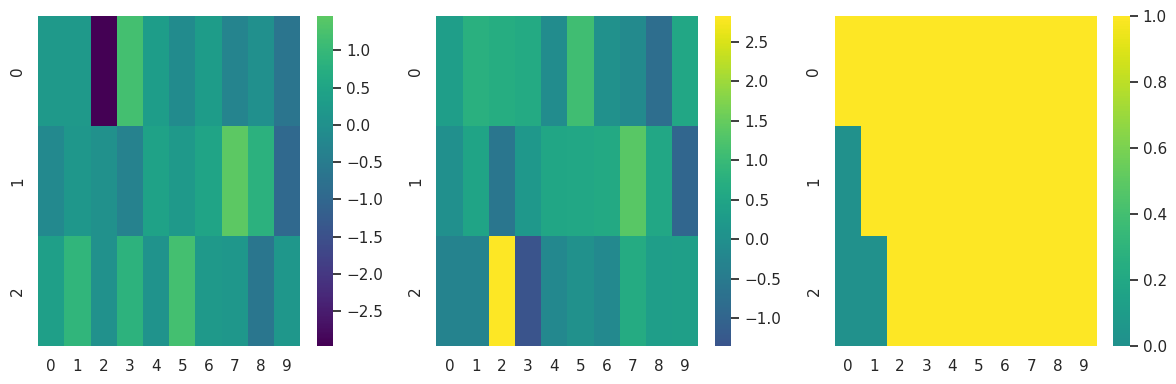

In [5]:
fa = sklearn_fa(n_components=z_dim, rotation='varimax')
res = fa.fit(X)

proc_trans = procrustes.orthogonal(np.asarray(res.components_.T), np.asarray(mask.T).astype(jnp.float32), scale=True)
print(f"The Procrustes error for the loading matrix is {proc_trans.error}")

# Heatmap of transformed loading matrix
fa_w_trans = proc_trans.t.T @ res.components_
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.heatmap(res.components_, cmap='viridis', fmt = ".2f", center = 0, ax=axes[0])
sns.heatmap(fa_w_trans, cmap='viridis', fmt = ".2f", center = 0, ax=axes[1])
sns.heatmap(mask, cmap='viridis', fmt = ".2f", center = 0, ax=axes[2])
fig.tight_layout()

## 2. E-step Investigation

Let's initialize a model and examine each part of the E-step computation:

E-step computation:
Ez + Ezz shape: (100, 12)


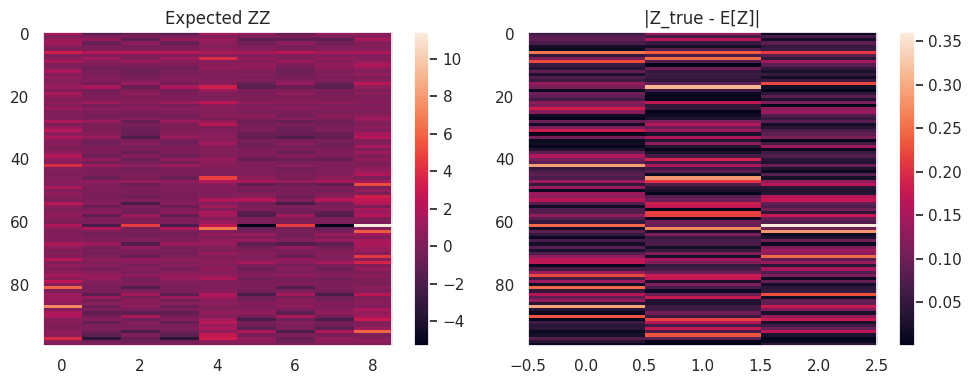

In [6]:
from sppcax.models import e_step

# Initialize model with known parameters
model = PPCA(n_components=n_components, n_features=n_features)

W_dist = MultivariateNormalGamma(
    loc=W_true.mT,  # Use true W for initialization
    scale_tril=jnp.eye(n_components)/100,
    mask=model.W_dist.mvn.mask,
    alpha=model.W_dist.gamma.alpha,
    beta=1.0
)

model = eqx.tree_at(lambda x: x.W_dist, model, W_dist)
mean = X.mean(0)
model = eqx.tree_at(lambda x: x.mean_, model, mean)

# Step through E-step computation
print("E-step computation:")

# Compute expectations
qz = e_step(model, X)
exp_stats = qz.expected_sufficient_statistics
print(f"Ez + Ezz shape: {exp_stats.shape}")

# Visualize E-step results
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.imshow(exp_stats[:, n_components:], aspect='auto')
plt.title('Expected ZZ')
plt.colorbar()

plt.subplot(122)
plt.imshow(jnp.abs(Z_true - Z_true.mean(0) - qz.mean), aspect='auto')
plt.title('|Z_true - E[Z]|')
plt.colorbar()

plt.tight_layout()
plt.show()

## 3. M-step Investigation

Now let's examine the M-step updates:

M-step computation:


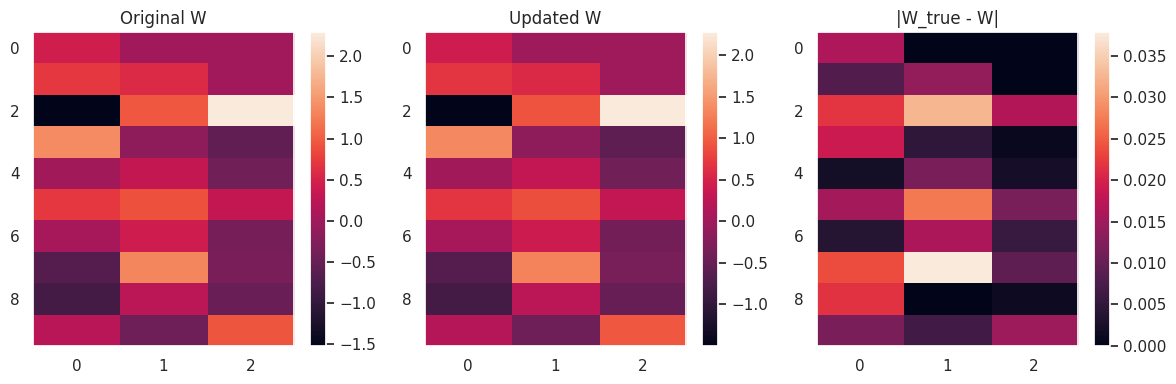

In [7]:
from sppcax.models import m_step

# Step through M-step computation
print("M-step computation:")

# 4. Update model
updated_model = m_step(model, X, qz)

# Visualize M-step results
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(model.W_dist.mean, aspect='auto')
plt.title('Original W')
plt.colorbar()

plt.subplot(132)
plt.imshow(updated_model.W_dist.mean, aspect='auto')
plt.title('Updated W')
plt.colorbar()

plt.subplot(133)
plt.imshow(jnp.abs(W_true.mT - updated_model.W_dist.mean), aspect='auto')
plt.title('|W_true - W|')
plt.colorbar()

plt.tight_layout()
plt.show()

## 4. Full Model Fitting

Let's test the complete fitting procedure:

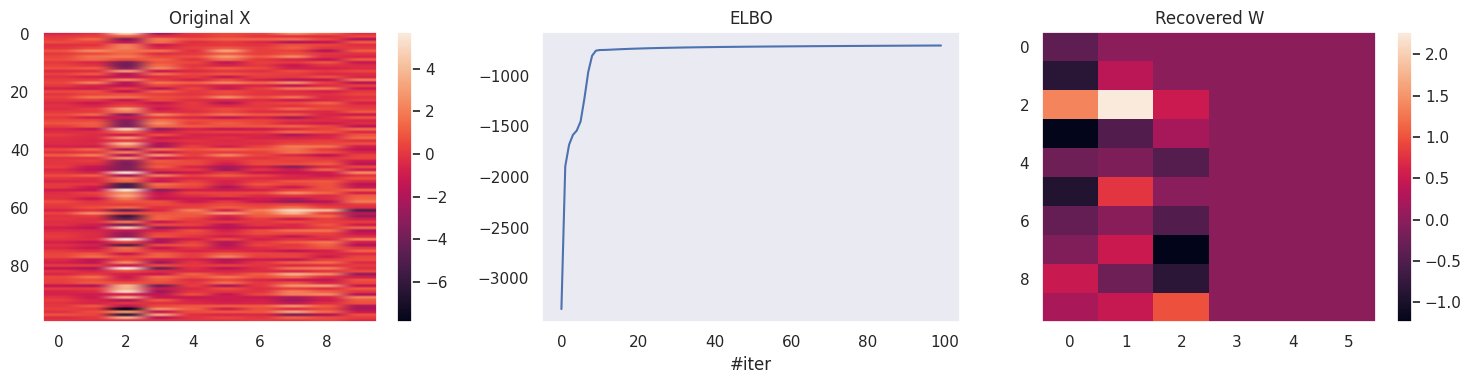

Reconstruction error: 0.010117
ARD posterior [7.44592068e-02 5.54458200e-02 8.34386781e-02 9.69986966e+03
 9.69386018e+03 9.82815024e+03]


In [8]:
from sppcax.models import fit, transform, inverse_transform

# Initialize model
model = PPCA(n_components=2*n_components, n_features=n_features)

# Fit model
fitted_model, elbos = fit(model, X, tol=1e-2)

# Transform data
qz = transform(fitted_model, X)

# inverse transform returns a multivariate normal distribution
X_reconstructed = inverse_transform(fitted_model, qz).mean

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(X, aspect='auto')
plt.title('Original X')
plt.colorbar()

plt.subplot(132)
plt.plot(elbos)
plt.title('ELBO')
plt.xlabel('#iter')

plt.subplot(133)
plt.imshow(fitted_model.W_dist.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", fitted_model.W_dist.gamma.mean)

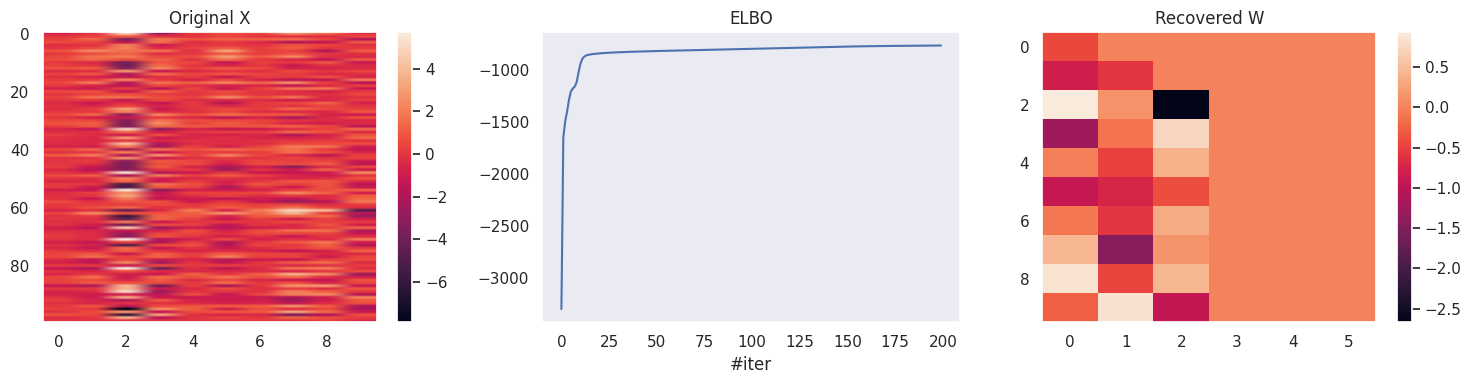

Reconstruction error: 0.007193
ARD posterior [1.14080527e-01 1.43015905e-01 7.24527953e-02 1.96492838e+04
 1.98218997e+04 1.98205504e+04]


In [9]:
# Initialize model
model = PFA(n_components=2 * n_components, n_features=n_features)

# Fit model
fitted_model, elbos = fit(model, X, tol=1e-3, n_iter=200)

# Transform data
qz = transform(fitted_model, X)

# inverse transform returns a multivariate normal distribution
X_reconstructed = inverse_transform(fitted_model, qz).mean

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(X, aspect='auto')
plt.title('Original X')
plt.colorbar()

plt.subplot(132)
plt.plot(elbos)
plt.title('ELBO')
plt.xlabel('#iter')

plt.subplot(133)
plt.imshow(fitted_model.W_dist.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", fitted_model.W_dist.gamma.mean)

## 5. Working with missing data

We illustrate here how to mask missing data.

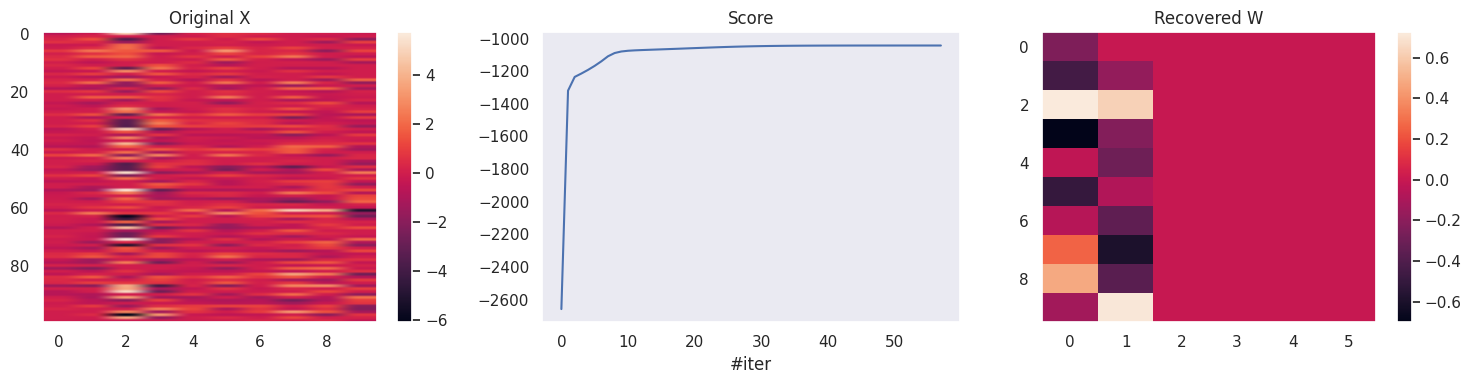

Reconstruction error: 0.873141
ARD posterior [3.39836949e+00 2.44550322e+00 5.60859314e+03 5.59296031e+03
 5.67619834e+03 5.66990627e+03]


In [10]:
# mask 20% of the observed features
key, _key = jr.split(key)
data_mask = jr.bernoulli(_key, p=.8, shape=X.shape)

# Initialize model
model = PFA(n_components=2 * n_components, n_features=n_features, data_mask=data_mask)

# Fit model
fitted_model, lls = fit(model, X, tol=1e-3, n_iter=200)

# Transform data
qz = transform(fitted_model, X, use_data_mask=True)

# inverse transform returns a multivariate normal distribution
X_reconstructed = inverse_transform(fitted_model, qz).mean

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(X * data_mask, aspect='auto')
plt.title('Original X')
plt.colorbar()

plt.subplot(132)
plt.plot(lls)
plt.title('Score')
plt.xlabel('#iter')

plt.subplot(133)
plt.imshow(fitted_model.W_dist.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean(jnp.square((X - X_reconstructed)))
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", fitted_model.W_dist.gamma.mean)

## 6. Passing uncertain measurements

Here, we illustrate here how to pass data with uncertainty associated with measurements.

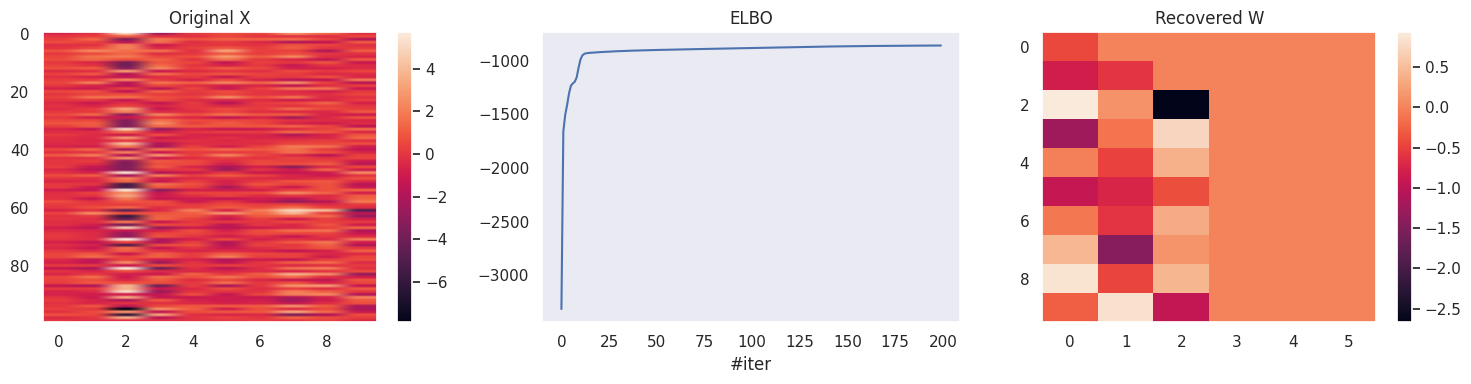

Reconstruction error: 0.007193
ARD posterior [1.14080527e-01 1.43015905e-01 7.24527953e-02 1.96492838e+04
 1.98218997e+04 1.98205504e+04]


In [11]:
# add uncertainty to observations
X_dist = MultivariateNormal(loc=X, precision=100*jnp.eye(n_features))

# Initialize model
model = PFA(n_components=2 * n_components, n_features=n_features)

# Fit model
fitted_model, elbos = fit(model, X_dist, tol=1e-3, n_iter=200)

# Transform data
qz = transform(fitted_model, X_dist)

# inverse transform returns a multivariate normal distribution
X_reconstructed = inverse_transform(fitted_model, qz).mean

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(X, aspect='auto')
plt.title('Original X')
plt.colorbar()

plt.subplot(132)
plt.plot(elbos)
plt.title('ELBO')
plt.xlabel('#iter')

plt.subplot(133)
plt.imshow(fitted_model.W_dist.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", fitted_model.W_dist.gamma.mean)

## 7. Model pruning with Bayesian model reduction

Here, we illustrate here how to pass data with uncertainty associated with measurements.

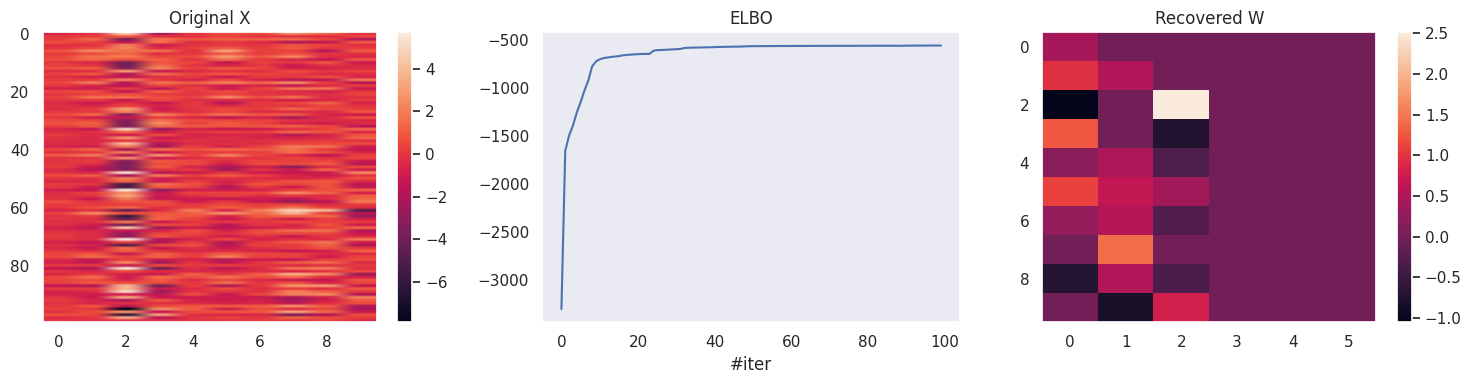

Reconstruction error: 0.007388
ARD posterior [5.95131262e-02 6.84664717e-02 5.56899999e-02 7.10337372e+02
 1.75670850e+03 6.60252420e+02]


In [25]:
# Initialize model
model = PFA(n_components=2 * n_components, n_features=n_features, random_state=jr.PRNGKey(111))

# Fit model
fitted_model, elbos = fit(model, X, tol=1e-3, n_iter=256, use_bmr=True, bmr_frequency=8)

# Transform data
qz = transform(fitted_model, X)

# inverse transform returns a multivariate normal distribution
X_reconstructed = inverse_transform(fitted_model, qz).mean

# Visualize results
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.imshow(X, aspect='auto')
plt.title('Original X')
plt.colorbar()

plt.subplot(132)
plt.plot(elbos)
plt.title('ELBO')
plt.xlabel('#iter')

plt.subplot(133)
plt.imshow(fitted_model.W_dist.mean, aspect='auto')
plt.title('Recovered W')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print reconstruction error
error = jnp.mean((X - X_reconstructed) ** 2)
print(f"Reconstruction error: {error:.6f}")

print("ARD posterior", fitted_model.W_dist.gamma.mean)

In [13]:
model = PFA(n_components=2 * n_components, n_features=n_features, random_state=jr.PRNGKey(111))

fitted_model, elbos = fit(model, X, tol=1e-6, n_iter=40)